<a href="https://www.kaggle.com/code/elakapoor/time-series-forecasting-using-moving-average-model?scriptVersionId=106383313" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1><center><font size="6">Prdeicting Odds on Horse Racing</font></center></h1>

<center><img src="https://images.unsplash.com/photo-1533284133567-0da9844151ce?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=871&q=80"></img></center>
Photo by Pietro Mattia on <a href="https://unsplash.com/?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX # used to predict the moving average process
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm                           # for series decompose
from statsmodels.graphics.tsaplots import plot_acf     # plot the auto correlation function
from statsmodels.tsa.stattools import adfuller         # test for the stationary time series
import matplotlib.pyplot as plt                        # data vizualizing library
import numpy as np                                     # data analysis library
import pandas as pd                                    # data analysis library

import warnings                                        # ignore warning
warnings.filterwarnings('ignore')

#%matplotlib inline                                     # magic command for data vizualization

import os                                              # reading the file path from the kaggle kernel
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/big-data-derby-2022/nyra_tracking_table.csv
/kaggle/input/big-data-derby-2022/nyra_start_table.csv
/kaggle/input/big-data-derby-2022/nyra_race_table.csv
/kaggle/input/big-data-derby-2022/nyra_2019_complete.csv


# Read the data

In [2]:
path = "/kaggle/input/big-data-derby-2022/nyra_2019_complete.csv"
df = pd.read_csv(path, header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8


#### Renaming the columns

In [3]:
df.rename(columns ={
    1:"date",
    16:"odds"
}, inplace = True)
df.head()

,0,date,2,3,4,5,6,7,8,9,10,11,12,13,14,15,odds,17
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8


Goal of the Competition<br>
The goal of this competition is to analyze horse racing tactics, drafting strategies, and path efficiency. You will develop a model using never-before-released coordinate data along with basic race information.<br>


1. track_id - char(3) 3 character id for the track the race took place at. AQU -Aqueduct, BEL - Belmont, SAR - Saratoga.
2. race_date - date date the race took place. YYYY-MM-DD
3. race_number - char(3) Number of the race. Passed as 3 characters but can be cast or converted to int for this data set
4. program_number - char(3) Program number of the horse in the race passed as 3 characters. Should remain 3 characters as it isn't limited to just numbers. Is essentially the unique identifier of the horse in the race.
5. trakus_index - int The common collection of point of the lat / long of the horse in the race passed as an integer. From what we can tell, it's collected every 0.25 seconds
6. latitude - float The latitude of the horse in the race passed as a floa
7. longitude - float The longitude of the horse in the race passed as a floa
8. distance_id - int  Distance of the race in furlongs passed as an integer. Example - 600 would be 6 furlongs.
9. course_type - char(1) The course the race was run over passed as one character. M - Hurdle, D - Dirt, O - Outer turf, I - Inner turf, T - turf.
10. track_condition - char(3) The condition of the course the race was run on passed as three characters. YL - Yielding, FM - Firm, SY - Sloppy, GD - Good, FT - Fast, MY - Muddy, SF - Soft.
11. run_up_distance - int Distance in feet of the gate to the start of the race passed as an integer.
12. race_type - char(5) The classification of the race passed as as five characters. STK - Stakes, WCL - Waiver Claiming, WMC - Waiver Maiden Claiming, SST - Starter Stakes, SHP - Starter Handicap, CLM - Claiming, STR - Starter Allowance, AOC - Allowance Optionl Claimer, SOC - Starter Optional Claimer, MCL - Maiden Claiming, ALW - Allowance, MSW - Maiden Special Weigh
13. purse -  Purse in US dollars of the race passed as an money with two decimal places.
14. post_time - char(5)  Time of day the race began passed as 5 character. Example - 01220 would be 12:20.
15. weight_carried - int  An integer of the weight carried by the horse in the race.
16. jockey - char(50) Name of the jockey on the horse in the race. 50 character max.
17. odds - int  Odds to win the race passed as an integer. Divide by 100 to derive the odds to 1. Example - 1280 would be 12.8-1.

#### Checking the number of rows and columns

In [4]:
df.shape

(5228430, 18)

#### checking the column type

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 18 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       object 
 1   date    object 
 2   2       int64  
 3   3       object 
 4   4       int64  
 5   5       float64
 6   6       float64
 7   7       int64  
 8   8       object 
 9   9       object 
 10  10      int64  
 11  11      object 
 12  12      float64
 13  13      int64  
 14  14      int64  
 15  15      object 
 16  odds    int64  
 17  17      int64  
dtypes: float64(3), int64(8), object(7)
memory usage: 718.0+ MB


#### selecting and grouping the column as per need

In [6]:
df_race = df.groupby("date")[["odds"]].sum()
df_race.head()

,odds
date,
2019-01-01,21430110
2019-01-04,20153180
2019-01-05,28994330
2019-01-06,19069365
2019-01-10,7521175


In [7]:
df_race.shape

(217, 1)

#### vizualizing the trends over time

Text(0, 0.5, 'odds')

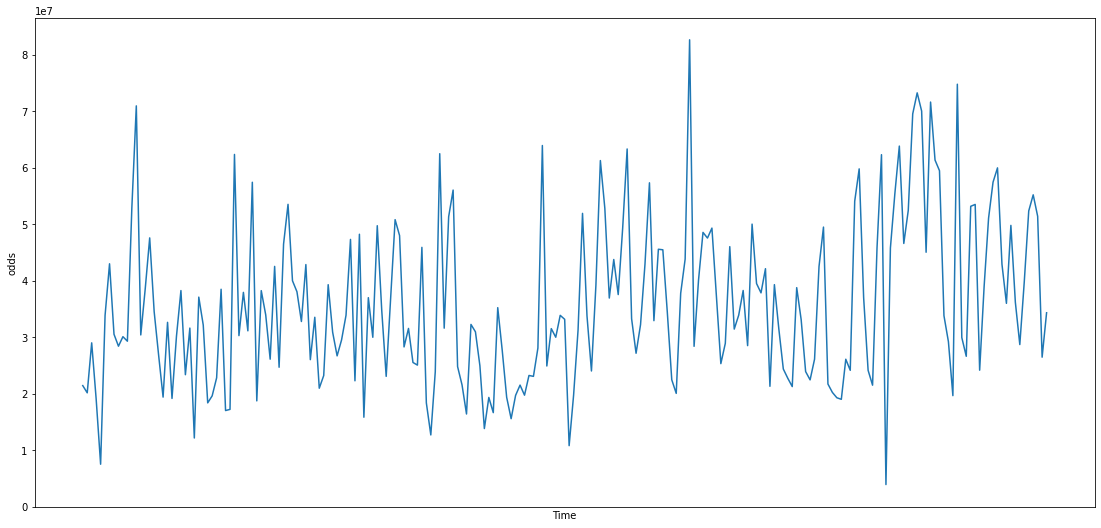

In [8]:
fig, ax = plt.subplots(figsize = (19, 9))

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

ax.plot(df_race['odds'])
ax.set_xlabel('Time')
ax.set_ylabel('odds')

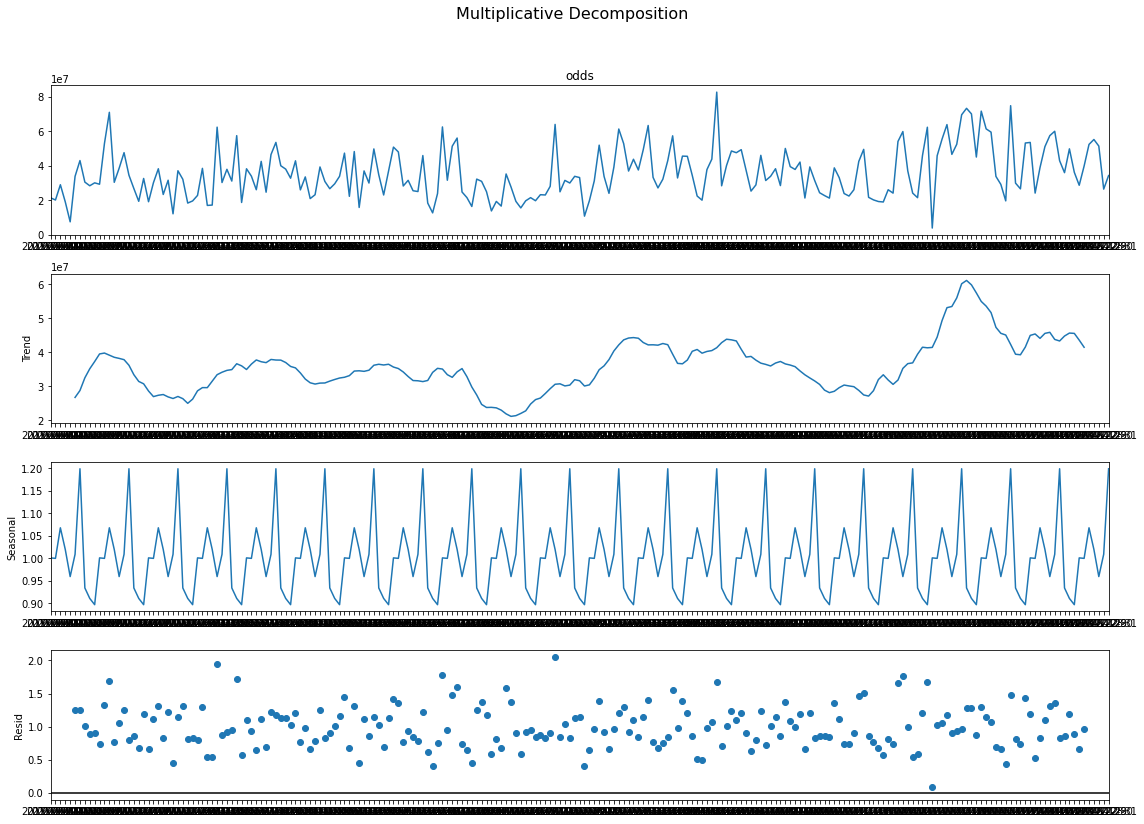

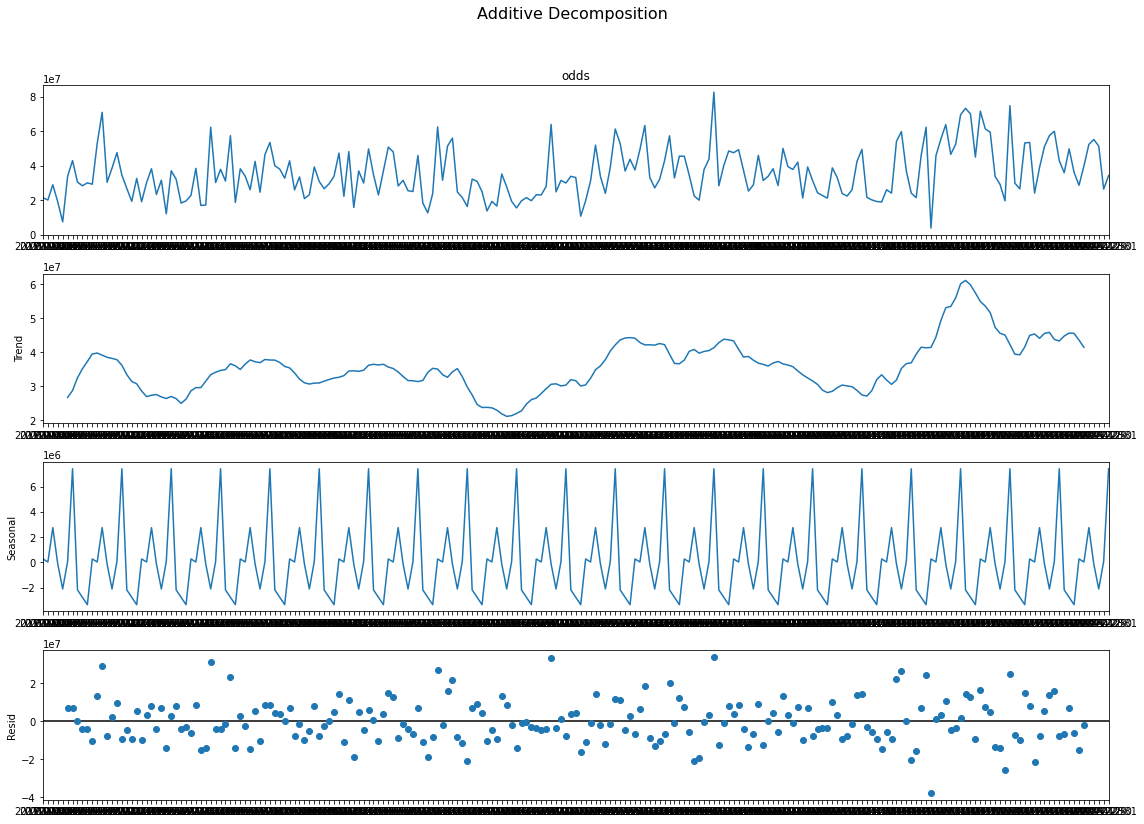

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
mul_decomposition = seasonal_decompose(df_race['odds'],
                                       model='multiplicative', period=10)

# Additive Decomposition
add_decomposition = seasonal_decompose(df_race['odds'],
                                       model='additive', period=10)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})

mul_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

add_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

The series above shows the pattern of peaks and troughs over the time. Hence, it can be said that series is not stationary w.r.t time.
Also, there is no cyclic pattern and hence we can safely say that there is no seasonal effect.<br>
If the magnitude of the seasonal component changes with time then we can say the series to be multiplicative else it is additive. In our case the magnitude of the component remains same so we can say that the series is additive in nature.<br>
Before starting the series analysis, we need to make sure of certain conditions. They are as follows:<br>
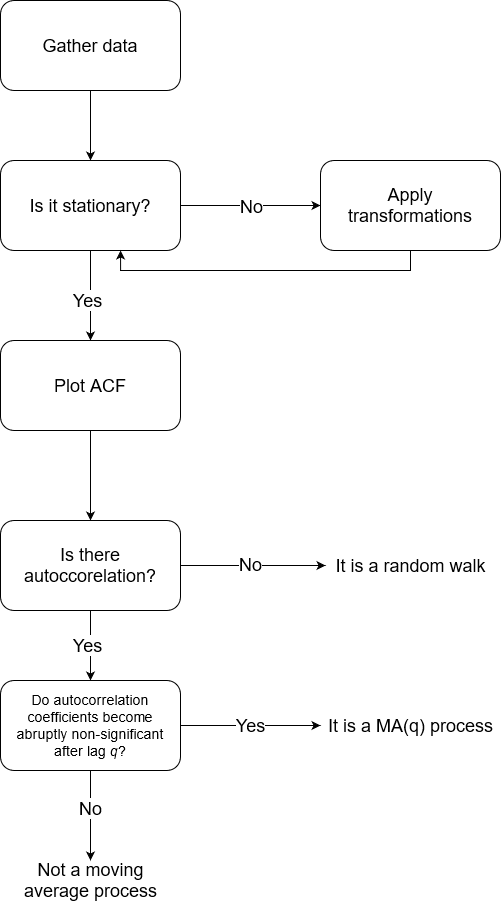<br>

Image take from Time Series in Python book.

# Test for stationary
A times series is defined as stationary if its statistical properties does not change over time. This means that the mean, variance and autocorrelation properties are independent of time. The moving average model assumes that the time series provided is stationary. Otherwise, model is not reliable and forecast is incorrect.<br>
The series that we are working with cleary shows that it is not statinary. Let us check for it's mean, variance and then perform ADF test.

## Mean

Text(0, 0.5, 'mean of odds')

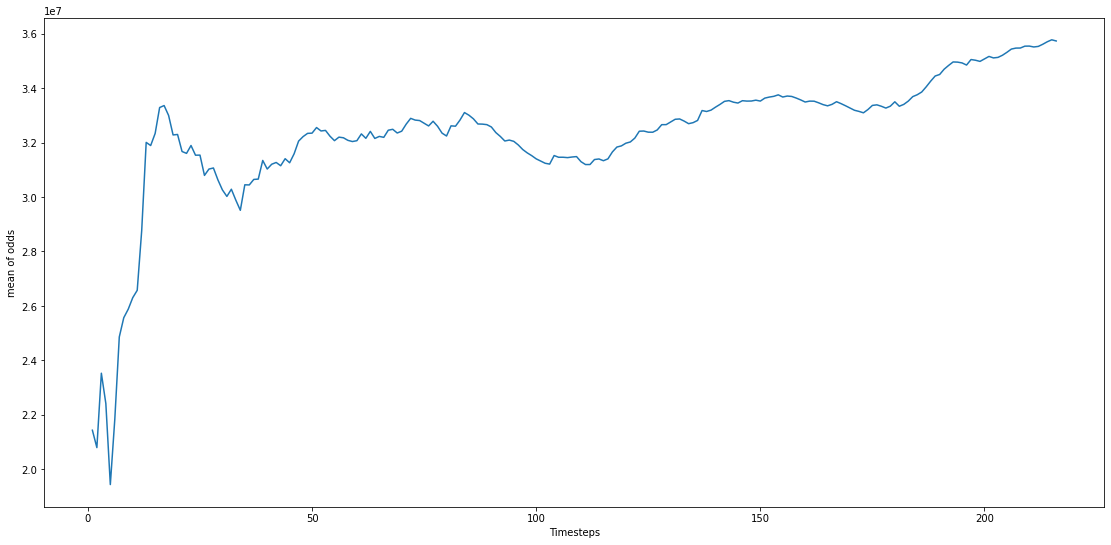

In [10]:
## checking the variation of mean over time
mean_func = []
for i in range(len(df_race["odds"])):
    mean_func.append(np.mean(df_race["odds"][:i]))

## vizualizing the variation of mean over time
fig, ax = plt.subplots(figsize = (19, 9))
ax.plot(mean_func)
ax.set_xlabel('Timesteps')
ax.set_ylabel('mean of odds')

From above we see that the mean of the series is increasing and decreasing w.r.t time. Hence, it can be said that the unit root is present and the series is non-stationary.

## Variance

Text(0, 0.5, 'Variance of odds')

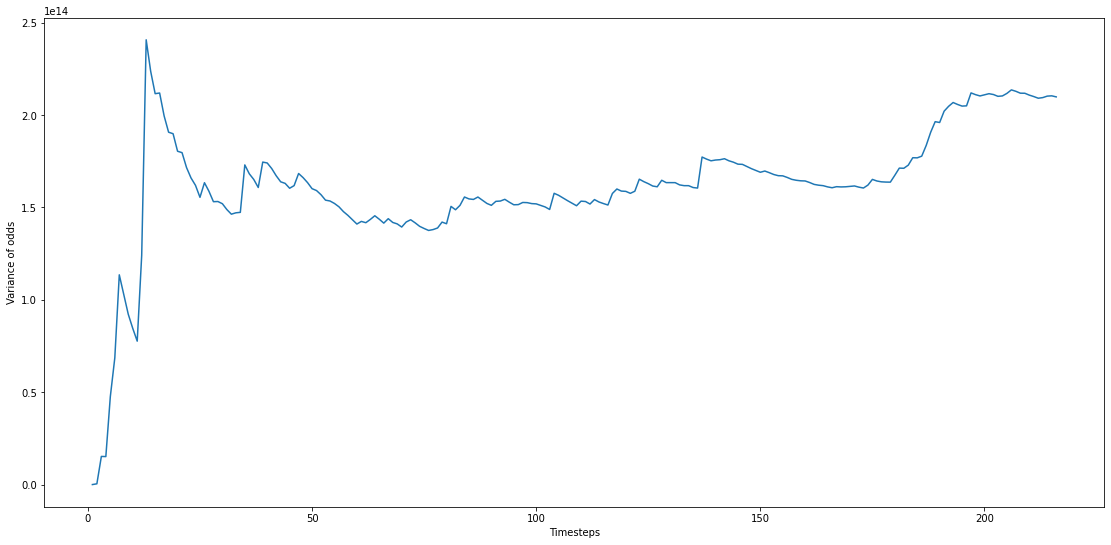

In [11]:
## checking the variation of variance over time
var_func = []
for i in range(len(df_race["odds"])):
    var_func.append(np.var(df_race["odds"][:i]))

## vizualizing the variation of variance over time
fig, ax = plt.subplots(figsize = (19, 9))
ax.plot(var_func)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Variance of odds')

The variation of variance over time states that the variance is time dependent and the series os non-stationary. Let us now check for the ADF test.

## Augmented Dickey-Fuller (ADF) test
The null hypothesis of ADF test verifies that there is a unit root present which makes the time series non-stationary. The alternative hypothesis is that there is no unit root and therefore the time series is non stationary.<br>
The result of the ADF test is a negative number. The greater the value of negative number the stronger is the rejection that series is non-stationary. Thus, desired is the result of achieving the stationary time series.<br>
p-value: < 0.05 then the series is stationary. It means that there are not unit roots, and so the series is stationary.<br>
p-value: > 0.05 then the series is non-stationary<br>

In [12]:
## ADF Test
ADF_result = adfuller(df_race['odds'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -3.1141607642965776
p-value: 0.025522823228175867


The above ADF test does not show a large negative number. Athough the p value < 0.05. Ths we can say that the series is non stationary and apply tranformations to make it stationary.

# Applying Transformation
The tranformation is a mathematecial process which aims stabalize the series by manipulating either it's mean or variance. The the process of tranformation make the series stationary. <b>Differencing</b> is the simplest means of transformation which stabilize the mean and removes and reduces the trend and seasonality effects.<br>
In differencing the change from one timestep to other is calculated. This is done by subtracting the previous time stamp from the present and the value obtained is the differenced value.<br>

y<sup>'</sup><sub>t</sub> = y<sub>t</sub> − y<sub>t − 1</sub><br>

Applying a log function to the series can stabilize its variance.<br>

The <b>first order differencing</b> is done when the difference is take only once. Taking the difference second time results in <b>second order differencing</b>
#### Untransform the series
The process of untransform is done to bring back the results to the original units of measurement. The predictions obtain will make more sense w.r.t original context.

In [13]:
## first order differencing
odds_diff = np.diff(df_race['odds'], n=1)

Text(0, 0.5, 'Odds (differenced)')

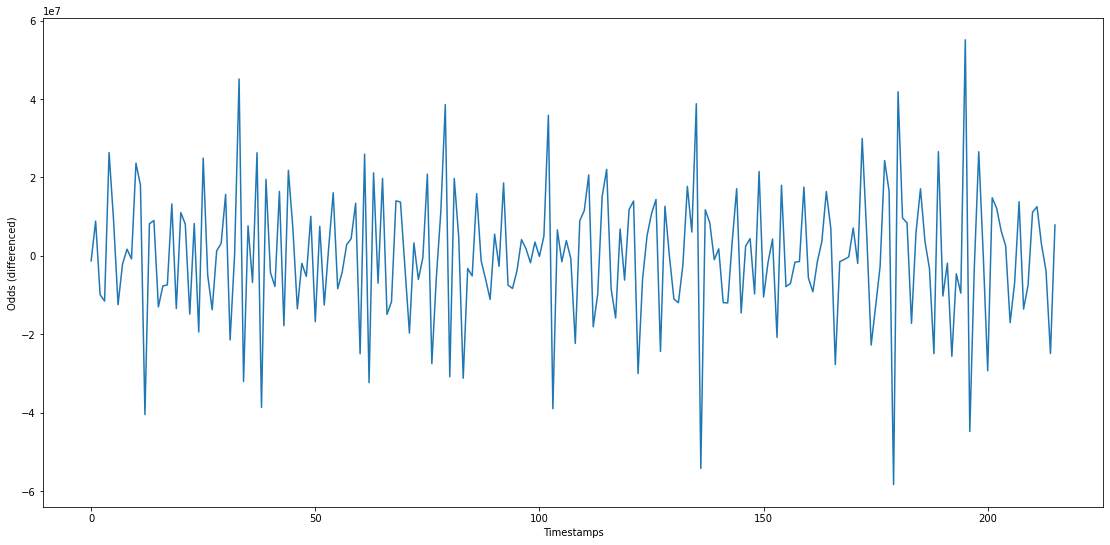

In [14]:
## vizualizing time series after first order differencing

fig, ax = plt.subplots(figsize = (19, 9))

ax.plot(odds_diff)
ax.set_xlabel('Timestamps')
ax.set_ylabel('Odds (differenced)')

In [15]:
## checking for stationary
ADF_result = adfuller(odds_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -8.465529335588588
p-value: 1.526189596548144e-13


The value of ADF is a large negative number also the p-vale is very small than 0.05. This make our series sattionary and now we can move to the next step of plotting ACF.

## Auto Correlation Function (ACF)

Correlation defines the extent of linear relationship between two variables. Thus, autocorrelation measures the relationship between the lagged values of time series. Lag is the number of timestamps seperating two values.<br>

In the ACF plot, the coefficient is the dependent variable while the lag is the independent varable. The coefficient at the lag 0 will always be equal to 1. This is because the linear relationship between a variable and itself at the same timestep should be perfect, and
therefore equal to 1.<br>

In the presence of a trend when plotting the ACF, the coefficients will be high for short lags, and we will see a linear decrease as the lag increases. If the data is seasonal, the ACF plot will also display cyclical patterns. Plotting the ACF for a stationary process can help us identify the presence of a random walk.<br>

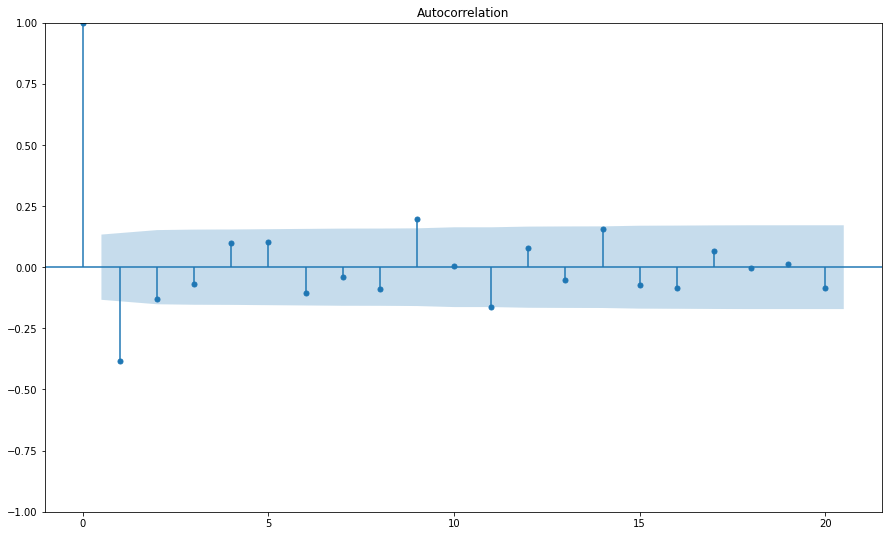

In [16]:
## plotting the ACF with the lags of 20

plt.rcParams["figure.figsize"] = (15,9)
plot_acf(odds_diff, lags=20);

In the above figure we see significant correlation until lag 1. This means that we have a stationary moving average process of order 1. Therefor we can use the first order moving average model to forecast our stationary time series.

# Defining moving average model
This model states that the current value is linearly dependent on the current and past error terms. The errors are assumed to be muually independent and normally distributed. The model is denoted by MA(q) where q is the order. Mathematically, the moving average process of order q is represented by:<br>
y<sub>t</sub> = μ + ϵ<sub>t</sub> + θ<sub>1</sub>ϵ<sub>t−1</sub> + θ<sub>2</sub>ϵ<sub>t−2</sub> +⋅⋅⋅+ θ<sub>q</sub>ϵ<sub>t−q</sub><br>
where:
y<sub>t</sub>: present value<br>
μ: mean of the series<br>
ϵ<sub>t</sub>: present error term<br>
ϵ<sub>t−1</sub>: past error terms<br>
θ<sub>q</sub>: The magnitude of the impact of past errors on the present value is quantified using a coefficient denoted as θq. <br>
The larger q is, the more past error terms affect the present value.

# Forecasting a moving average process
To forecast we have taken a stationary series. Now we will split the data into training and testing set in the ratio 9:1. Note that we are taking the differenced odds series for the further analysis as it is this series which make the data stationary.

In [17]:
## splitting the series in 9:1 ratio. 
df_diff = pd.DataFrame({'odds_diff': odds_diff})

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

## printing the length of each series
print(len(train))
print(len(test))

194
22


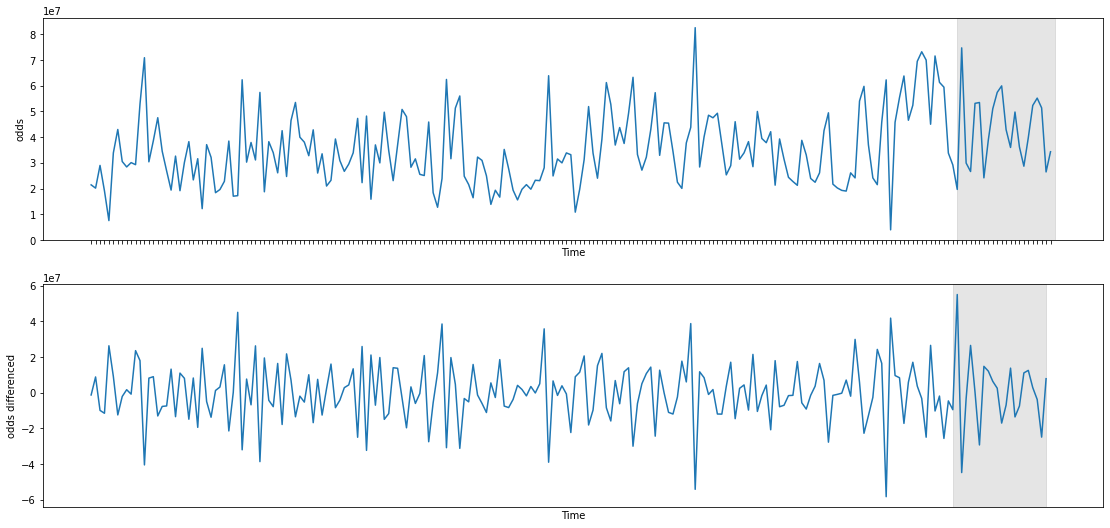

In [18]:
## vizaulizing the train and test series
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (19, 9))

ax1.plot(df_race['odds'])
ax1.set_xlabel('Time')
ax1.set_ylabel('odds')
ax1.axvspan(195, 217, color='#808080', alpha=0.2)

ax2.plot(df_diff['odds_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('odds differenced')
ax2.axvspan(194, 215, color='#808080', alpha=0.2)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

In [19]:
def rolling_forecast(df, train_len, horizon, window, method):

    # total length is the sum of train and test set length
    total_len = train_len + horizon
    
    # creating if loop taking the method
    if method == 'mean':
        
        # creating the empty list to store the values
        pred_mean = []
        
        # for loop stating start, stop and step values
        for i in range(train_len, total_len, window):
            # storing the mean of ith value in mean variable
            mean = np.mean(df[:i].values)
            # store the lastest value obtain to the end of the list
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [20]:
# setting up the variables
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()


,odds_diff,pred_mean,pred_last_value,pred_MA
194,-9543235,40034.175258,-4604360,1.711413e+07
195,55096960,-9110.794872,-9543235,2.138283e+07
196,-44821660,272042.627551,55096960,-2.000783e+07
197,-3311695,43140.583756,-44821660,1.381464e+07
198,26534525,26196.969697,-3311695,1.551486e+07


Text(0, 0.5, 'Odds')

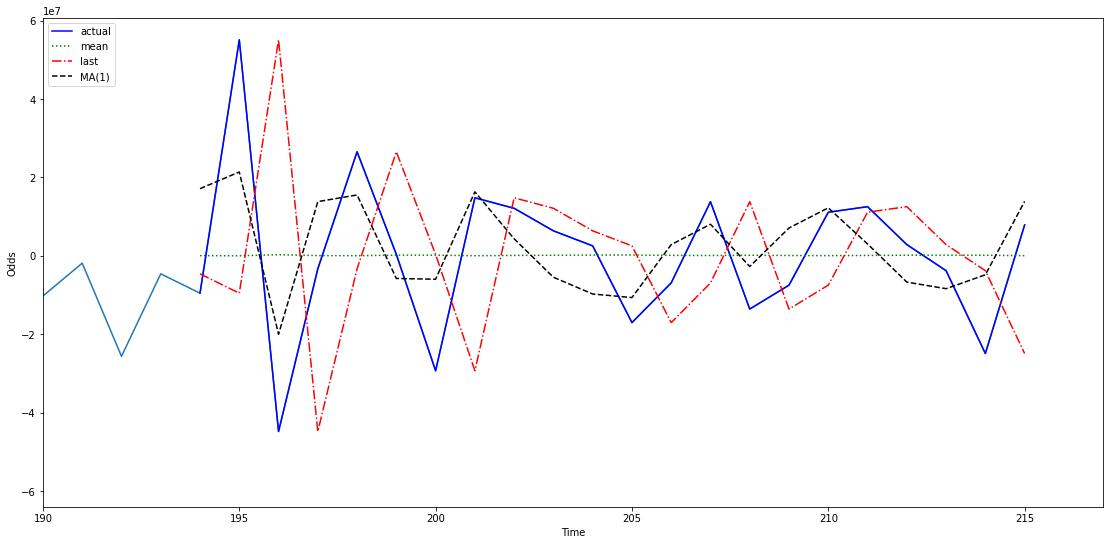

In [21]:
# specifying up the figure size
fig, ax = plt.subplots(figsize = (19, 9))

# specying original and forecast series 
ax.plot(df_diff['odds_diff'])
ax.plot(pred_df['odds_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(1)')

# locking the legend
ax.legend(loc=2)
# taking the x-range of importance
ax.set_xlim(190, 217)

# setting the x label
ax.set_xlabel('Time')
# setting the y label
ax.set_ylabel('Odds')

From above figure:
1. The mean is almost a straight line
2. Forecast obtain using the last is shifted by 1
3. The MA forecast closely follows the original series<br>

To find the performance of the models we will use the MSE function imported from sklearn package. The model having the lowest MSE will be the best performing model.

In [22]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['odds_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['odds_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['odds_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

405591792009639.2 1094400764056152.0 225344147605229.72


Text(0, 0.5, 'MSE')

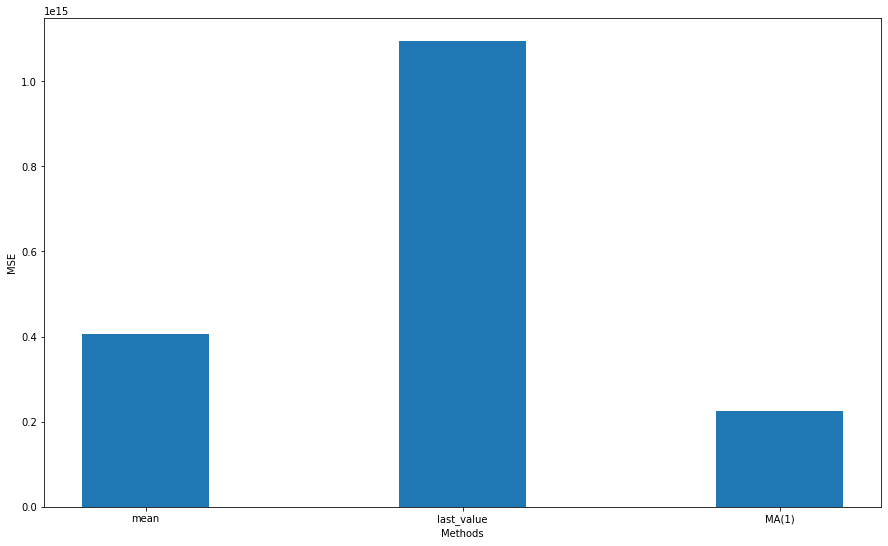

In [23]:
# plotting the MSE
fig, ax = plt.subplots(figsize = (15, 9))

x = ['mean', 'last_value', 'MA(1)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')

From above we see that the MA provides the lowest MSE value. Thus, this is the best model among the above three we used for forecasting.

### Untranforming the series
The prediction obtained above uses the differenced series. We need to undifference it to bring it back to original form.<br>

In order to reverse our first-order difference, we need to add an initial value y<sub>0</sub> to the first differenced value y<sup>'</sup><sub>1</sub>. That way, we can recover y<sub>1</sub> in its original scale.<br>
y<sub>1</sub> = y<sub>0</sub> + y<sup>'</sup><sub>1</sub> = y<sub>0</sub> + y<sub>1</sub> − y<sub>0</sub> = y<sub>1</sub>

In [24]:
## crating empty series to store values
df_race['pred_odds'] = pd.Series()
## predicted test series in untranform form = first term of original test series + cumulative sum of predicted series using MA
## applying the cumulative sum once will undo a first-order differencing
df_race['pred_odds'][195:] = df_race['odds'].iloc[195] + pred_df['pred_MA'].cumsum()

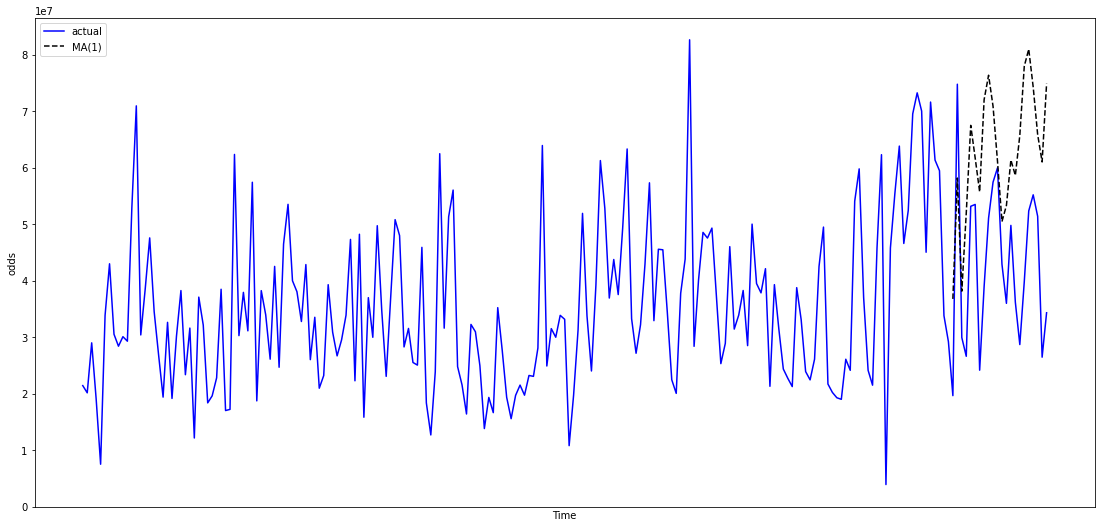

In [25]:
## plotting the untranform series
fig, ax = plt.subplots(figsize = (19, 9))

ax.plot(df_race['odds'], 'b-', label='actual') ## actual test series
ax.plot(df_race['pred_odds'], 'k--', label='MA(1)') ## predicted test series

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('odds')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

In [26]:
## checking the MSE between the predicted and actutal test series
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(df_race['odds'].iloc[195:], df_race['pred_odds'].iloc[195:])

print(mae_MA_undiff)

21159180.669018287


The above notebook is based on the "Time Series Forecasting in Python by Marco Peixeiro"